Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.053388 -0.096768       1        1  15.699789
6      0.091577  0.100403       2        1  14.461751
7      0.043624  0.214225       3        1  13.629890
2      0.077960  0.047603       4        1  11.686770
8      0.108689 -0.051774       5        1   9.895426
5      0.143890 -0.031395       6        1   7.915583
4     -0.161545 -0.042560       7        1   7.615908
0      0.034951 -0.165096       8        1   7.202599
3     -0.164454 -0.035537       9        1   6.451575
9     -0.228080  0.060899      10        1   5.440710, topic_info=         Term        Freq       Total Category  logprob  loglift
11       skin  362.000000  362.000000  Default  30.0000  30.0000
334  headache  187.000000  187.000000  Default  29.0000  29.0000
630     cough  140.000000  140.000000  Default  28.0000  28.0000
8        rash  187.000000  187.000000  Default  27.0000  27.0000
29       pain  290.000000  290.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
146   started    6.628020   19.875132  Topic10  -5.0764   1.8131
229       lot    9.823012  341.103216  Topic10  -4.6830  -0.6362
241      time    8.123792   98.086550  Topic10  -4.8729   0.4202
37       like    7.839113   82.643267  Topic10  -4.9086   0.5559
149       ive    9.575548  623.768872  Topic10  -4.7085  -1.2653

[635 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
97        2  0.052118  abdomen
97        6  0.052118  abdomen
97        7  0.781773  abdomen
97        9  0.052118  abdomen
925       1  0.109060  ability
...     ...       ...      ...
449       2  0.775441   yellow
449       3  0.016499   yellow
449       4  0.032998   yellow
449       5  0.016499   yellow
449       6  0.049496   yellow

[1328 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 8, 3, 9, 6, 5, 1, 4, 10])

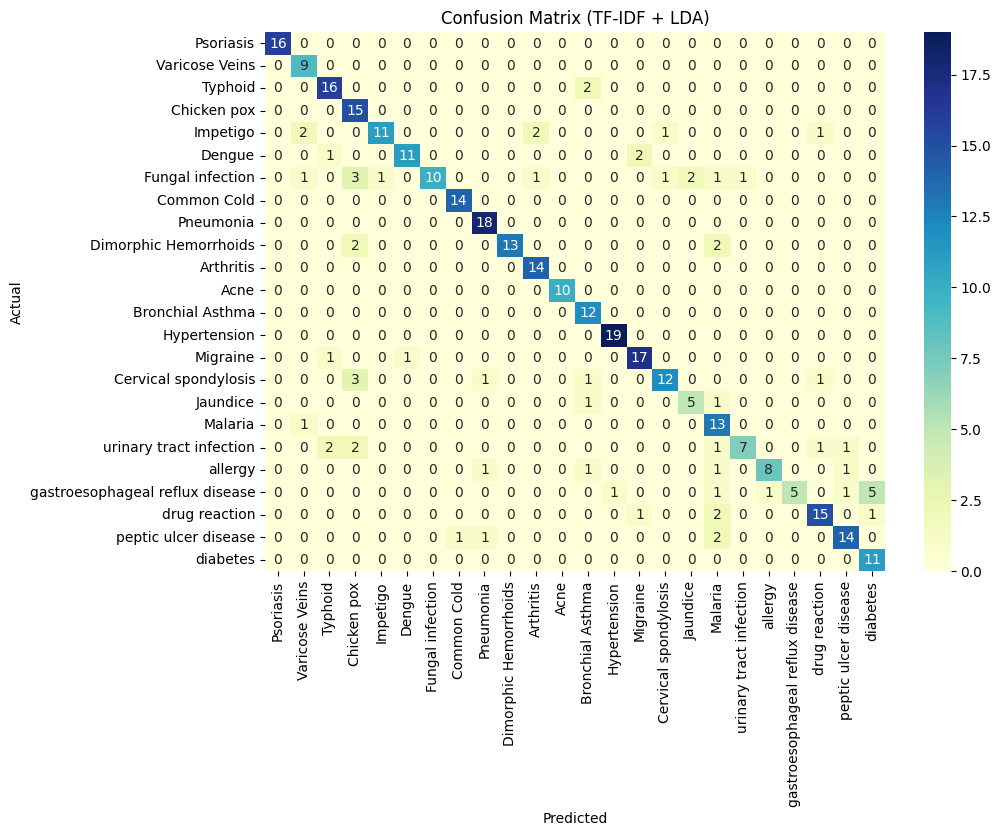

Accuracy Score: 0.8194444444444444
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        16
                      Arthritis       0.69      1.00      0.82         9
               Bronchial Asthma       0.80      0.89      0.84        18
           Cervical spondylosis       0.60      1.00      0.75        15
                    Chicken pox       0.92      0.65      0.76        17
                    Common Cold       0.92      0.79      0.85        14
                         Dengue       1.00      0.48      0.65        21
          Dimorphic Hemorrhoids       0.93      1.00      0.97        14
               Fungal infection       0.86      1.00      0.92        18
                   Hypertension       1.00      0.76      0.87        17
                       Impetigo       0.82      1.00      0.90        14
                       Jaundice       1.00      1.00      1.00        10
               

In [6]:
!pip install pyLDAvis
import pandas as pd
import string
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
import numpy as np
import pyLDAvis
import pyLDAvis.gensim
from IPython.display import display

# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Define text cleaning function
def clean_text(sent):
    sent = sent.translate(str.maketrans('', '', string.punctuation)).strip()
    words = word_tokenize(sent)
    words = [word for word in words if word not in stop_words]
    return " ".join(words).lower()

# Load and preprocess dataset
orig_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Moayad/Symptom2Disease.csv")
orig_df.drop("Unnamed: 0", inplace=True, axis=1)
orig_df["text"] = orig_df["text"].apply(clean_text)

# Tokenization and Lemmatization
lemmatizer = WordNetLemmatizer()
tokens = [word_tokenize(sen) for sen in orig_df.text]
lemmatized_tokens = [[lemmatizer.lemmatize(w.lower()) for w in token] for token in tokens]
filtered_words = [[word for word in tokens if word not in stop_words] for tokens in lemmatized_tokens]
orig_df['tokens'] = filtered_words

# Create Gensim dictionary and corpus for LDA
dictionary = Dictionary(orig_df['tokens'])
corpus = [dictionary.doc2bow(text) for text in orig_df['tokens']]

# Apply LDA using Gensim
num_topics = 10  # Number of topics
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Visualize topics using pyLDAvis
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.enable_notebook()  # Ensure it renders properly in notebooks
display(vis)

# Extract topic distribution for each document
topic_distributions = [lda_model.get_document_topics(doc) for doc in corpus]
topic_features = []
for doc_topics in topic_distributions:
    topic_row = [0] * num_topics
    for topic_id, prob in doc_topics:
        topic_row[topic_id] = prob
    topic_features.append(topic_row)

topic_features = np.array(topic_features)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = vectorizer.fit_transform(orig_df['text']).toarray()
labels = orig_df['label']

# Combine TF-IDF features with LDA topic features
features_combined = np.hstack([features, topic_features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_combined, orig_df['label'], test_size=0.3, random_state=82)

# Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Confusion Matrix and Accuracy
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=[idx2dis[idx] for idx in range(len(idx2dis))],
            yticklabels=[idx2dis[idx] for idx in range(len(idx2dis))])
plt.title('Confusion Matrix (TF-IDF + LDA)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Accuracy and Classification Report
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
